# Validation Dataset

```{contents}
```

## Validation (test) dataset sources

| Dataset 	| Reference 	| Disease 	| Raw Data Source 	| Download Sample Size 	| Population 	| Platform 	|
|---	|---	|---	|---	|---	|---	|---	|
| StJude AML02 	| [Rubnitz et al., 2010](https://pubmed.ncbi.nlm.nih.gov/20451454/) 	| AML 	| St. Jude Children's 	| 159 	| Pediatric 	| 450k 	|
| StJude AML08 	| [Rubnitz et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31246522/) 	| AML 	| St. Jude Children's 	| 42 	| Pediatric 	| 450k 	|

```{note}
The downloaded data contained an additional 95 liver methylation samples, so the total number of samples initially is 324. These will be filtered out in further steps.
```

## Step 1. Process raw data to get methylation beta values

This step will use SeSAMe ([Zhou et al. , 2018](https://pubmed.ncbi.nlm.nih.gov/30085201/)) to take signal intensity data (red and green .idat files) and convert them to beta values, which represent the % of methylation for each CpG site.

Process command:

    python -m methylprep -v process -d <directory> --all --batch_size 199
    

```{note}
From this point on we will move from using `python3.7` to using `python3.8`.
```

### Where the data at?

In [1]:
input_path_test_data = '/mnt/d/MethylScore/Raw_Data/LambaPrivate_StJude_AML02_AML08_Methyl450k/'

zhou2016_probes_path = '/mnt/d/MethylScore/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

output_path = '../../Data/Intermediate_Files/'

### Load Dataframes

In [2]:
import methylcheck
import pandas as pd

# Load the dataframes from the input paths
df = methylcheck.load(input_path_test_data, silent=True)

# Sort sample index
df = df.T.sort_index().T

print(f' Dataset (df) contains {df.shape[0]} rows (5mC sites/probes) and {df.shape[1]} columns (samples).')

 Dataset (df) contains 485512 rows (5mC sites/probes) and 324 columns (samples).


## Step 2. Load and process clinical data

In [3]:
# Import functions to clean up clinical data
import sys
sys.path.insert(0, '..')
from source.clinical_data_cleanup_functions import *

# Call functions to merge, index and clean clinical data files
labels_aml02         = clean_aml02       (merge_index_aml02())
labels_aml08         = clean_aml08       (merge_index_aml08())


# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml02, labels_aml08] ,axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df.T.index)].sort_index()

print('The clinical data has been indexed and cleaned.\n\
Exclusion of samples may be applied depending on the analysis.')

The clinical data has been indexed and cleaned.
Exclusion of samples may be applied depending on the analysis.


## Step 3. Remove suboptimal probes

There are several critera for exclusion of probes: Areas that have polymorphisms, cross-hybridization, repeat sequence elements, or base color changes can affect probe quality. Below are publications that have benchmarked probe quality and have provided lists of probes to exclude:

- [Chen et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3592906/)
- [Price et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3740789/)
- [Naeem et al., 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3943510/)
- [DacaRoszak et al., 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659175/)
- [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930)

This function removes proves listed as sub-optimal according to [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930). For the .tsv file containing the annotated probes, download the paper's supplementary material. See figure 5 of their paper for detailed description.

In [4]:
def exclude_suboptimal_probes(df):
    '''This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

    For the .tsv file containing the annotated probes, download the paper's
    supplementary material.
    '''
    # Load the list of suboptimal probes
    zhou2016_probes = pd.read_csv(zhou2016_probes_path, sep='\t',index_col=0)

    # Select the probes that are listed as suboptimal
    unreliable_probes = list(zhou2016_probes[zhou2016_probes['MASK.general'] == True].index)

    # Remove the unreliable probes from the dataframe
    df_ = df[~df.index.isin(unreliable_probes)]
    
    print(
        f'Removed {df.shape[0]-df_.shape[0]} suboptimal probes. {df_.shape[0]} probes remaining.')

    return(df_)

df = exclude_suboptimal_probes(df)

Removed 47514 suboptimal probes. 437998 probes remaining.


## Step 4. Remove sex-linked probes

In [5]:
df = methylcheck.exclude_sex_control_probes(df, '450k', no_sex=True, no_control=False, verbose=True)

450k: Removed 10623 sex-linked probes from 324 samples. 427375 probes remaining.


### Evaluate Missing Values

<Axes: >

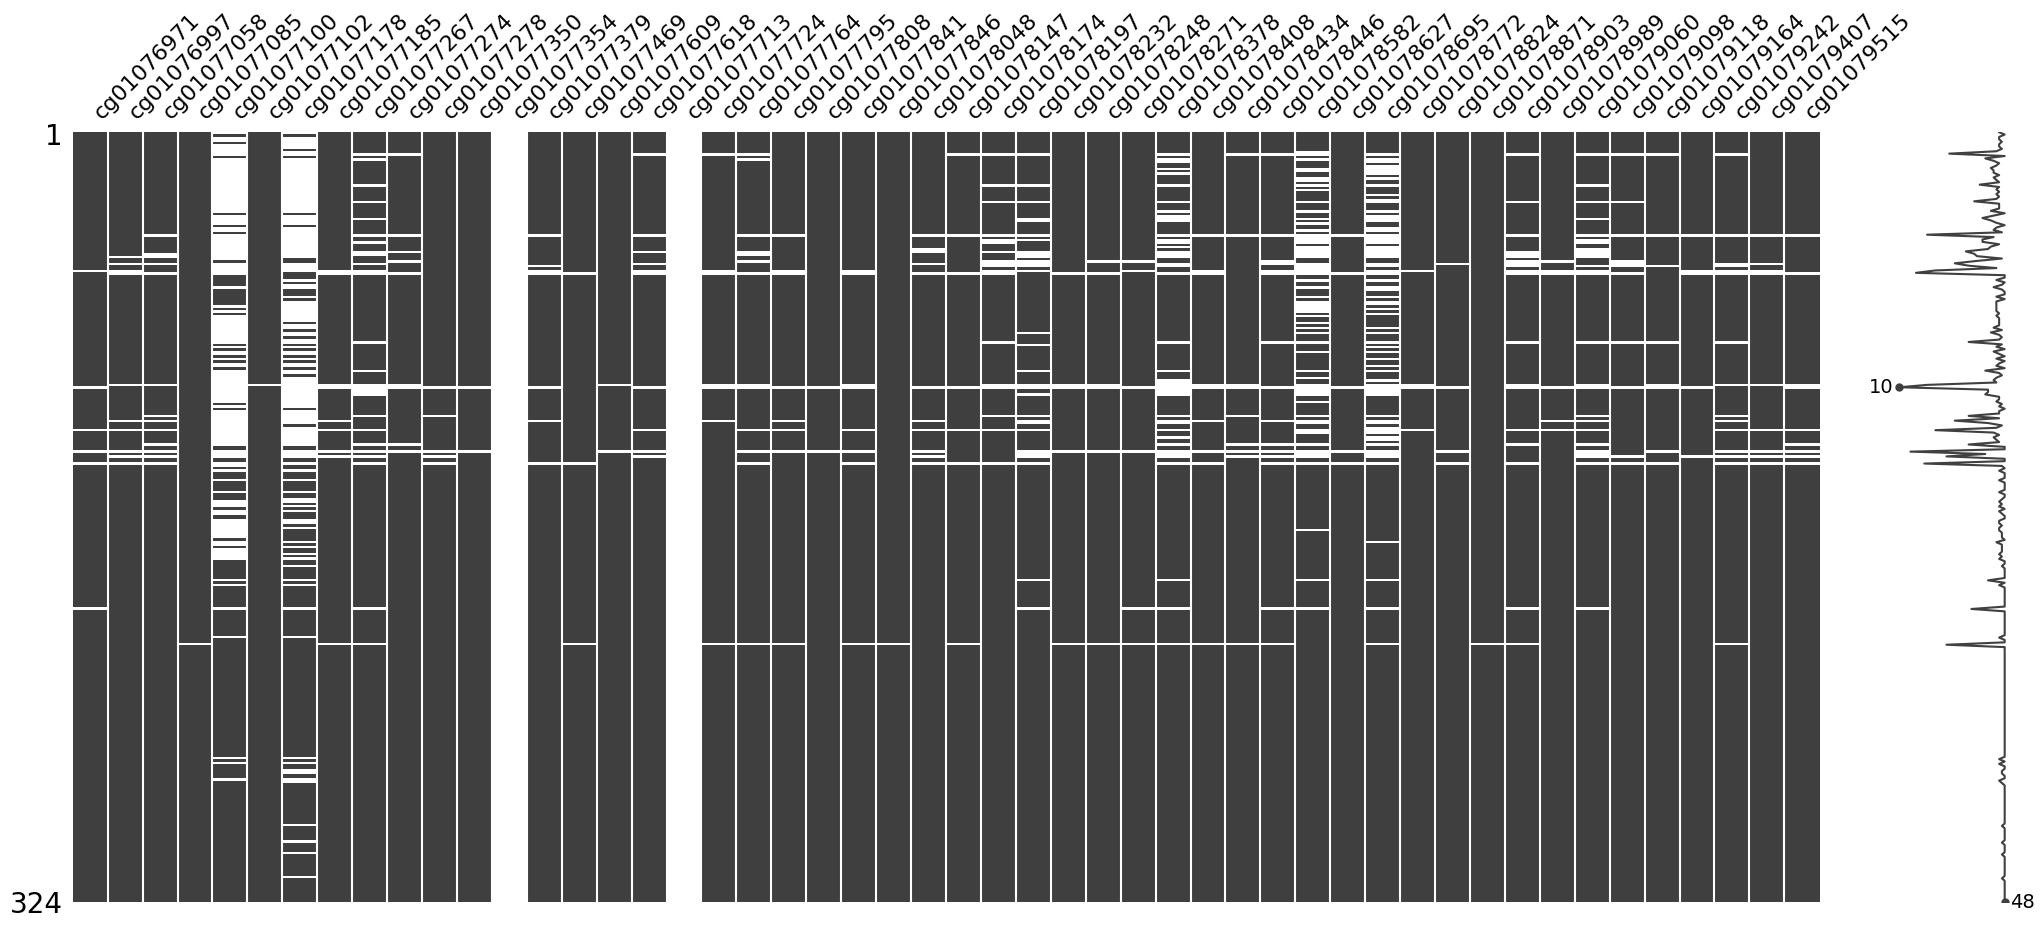

In [6]:
import missingno as msno

# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 5. Remove non-hematopoietic samples

In [7]:
import pandas as pd

def remove_non_hematopoietic_samples(df1: pd.DataFrame, df_labels: pd.DataFrame) -> pd.DataFrame:
    """
    Function to remove samples not present in the AML02 or AML08 clinical dataset.
    
    Args:
    df1: DataFrame containing the initial set of samples.
    df_labels: DataFrame containing the clinical dataset.
    
    Returns:
    df2: DataFrame after removing samples not present in the clinical dataset.
    """

    df2 = df1.T.loc[df1.T.index.isin(df_labels.index)].T

    print(
        f'Removed {df1.shape[1]-df2.shape[1]} samples not present in AML02 or AML08 clinical datasets.\
 {df2.shape[1]} samples remaining.')
    
    return df2

df = remove_non_hematopoietic_samples(df, df_labels)


Removed 95 samples not present in AML02 or AML08 clinical datasets. 229 samples remaining.


## Step 6. Exclude samples in which >20% of probes have failed p-values

A strict metric implemented by Illumina quality control process is `FAIL by pval`, which happens if, for a given sample, the detection p-value is >0.05 in >20% of probes.

Recall that detection p-values measure how likely it is that signals are background fluorescence. There are a few methods for calculating these:  ```SeSAMe``` and ```methylprep``` implement pOOBAH, which stands for P-value Out Of Band (OOB) probes for Array Hybridization. For more, see SeSAMe's paper in [Zhou et al. , 2018](https://pubmed.ncbi.nlm.nih.gov/30085201/).

In other words, we will exclude samples that Illumina QC categorizes as FAIL(pval) for meeting the condition: (pOOBAH > 0.05) >20% probes. Here, failed probes are listed as `NaN`, so we will count the number of `NaN` values in each sample and exclude samples that have more than 20% `NaN` values.

In [8]:
def exclude_failed_samples(df2):
    '''This function removes samples that have more than 20% NaN values.'''

    # Calculate the number of NaN values in each sample
    nan_count = df2.isna().sum()

    # Calculate the total number of probes (rows) in the DataFrame
    total_probes = df2.shape[0]

    # Calculate the percentage of NaN values for each sample
    nan_percentage = (nan_count / total_probes) * 100

    # Identify samples that meet the condition of having more than 20% NaN values
    samples_to_exclude = nan_percentage[nan_percentage > 20].index

    # Exclude samples that meet the condition from the DataFrame
    filtered_df2 = df2.drop(samples_to_exclude, axis=1)
    
    # Print the number of samples before and after filtering
    print(
    f"Removed {df2.shape[1]-filtered_df2.shape[1]} samples ({round((df2.shape[1]-filtered_df2.shape[1])/df2.shape[1]*100,2)}%). {filtered_df2.shape[1]} samples remaining."
    )
    
    return filtered_df2

df = exclude_failed_samples(df)


Removed 28 samples (12.23%). 201 samples remaining.


## Step 7. Exclude CpG probes that are missing in >5% of samples

In [9]:
def probe_cutoff(qc_betas, threshold):
    qc_betas2 = qc_betas.dropna(axis=0, thresh = int(threshold*qc_betas.shape[1]))
    print(f'{qc_betas.shape[0] - qc_betas2.shape[0]} probes removed. {qc_betas2.shape[0]} probes remaining.')

    return(qc_betas2)

df = probe_cutoff(df, threshold=0.95)

69536 probes removed. 357839 probes remaining.


### Evaluate Missing Values

<Axes: >

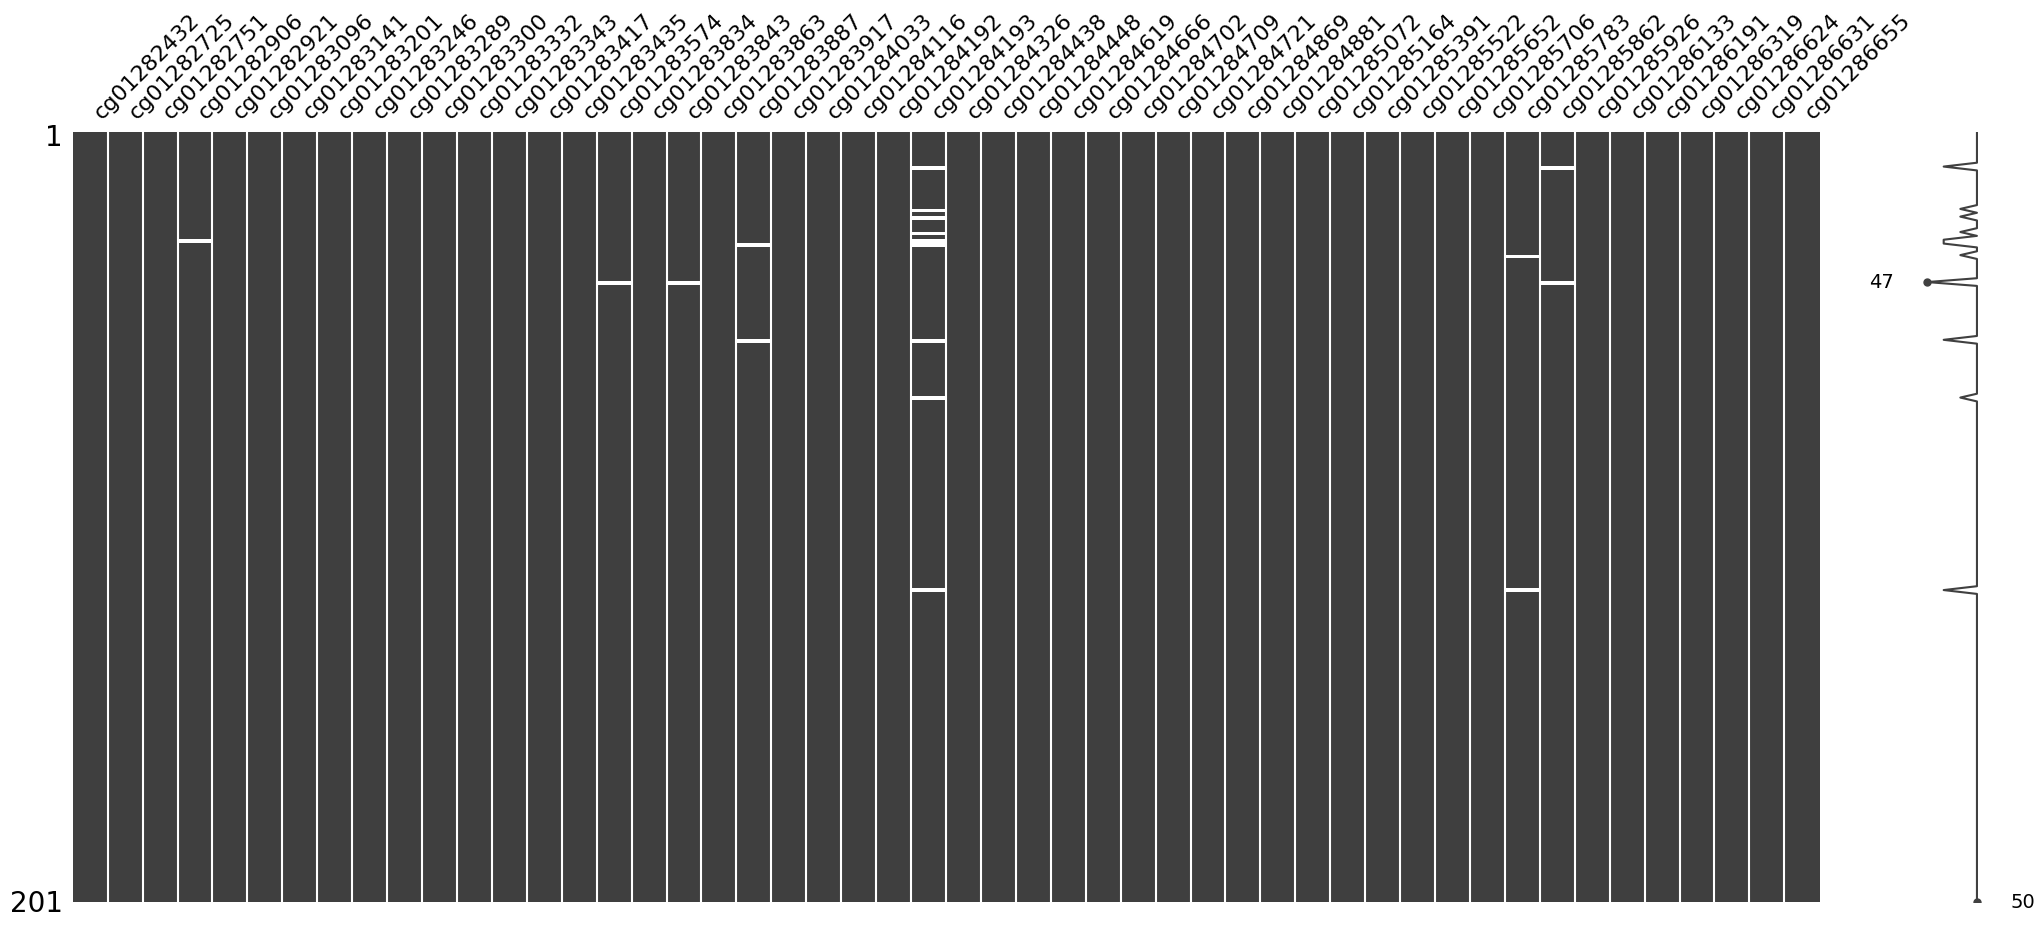

In [10]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 7. Impute remaining missing values

- __Method__: Mean by batch (it replaces each missing value by averaging all the known values for that CpG across samples within their batch).

- __Simple mean is recommended for methylation β-values__:

    _In conclusion, the consolidated and manufacturer encouraged practice to use β-value seems appropriate for DNA methylation data imputation. The choice of the best imputation method is somewhat more subtle and depends essentially on the available computational resources and the amount of missing values. Independently of the expected missingness mechanisms, regression-based methods provide on average more accurate estimates of the missing values. However, imputations with regression methods in the presence of limited computational resources can be a rather challenging task. In such cases, the simple mean approach can surprisingly be a better choice than more sophisticated methods_ ([Lena et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32600298/)).

- __This step inevitably introduces bias__: More sophisticated methods, however, also do. Benchmarks done by the paper above and others reported that the increase in error across methods is roughly similar ([see here](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)), which places `imputation by mean` as an equivalently error-prone method compared to others but vastly simpler and faster.

In [11]:
import pandas as pd

# Impute missing values
df = df.fillna(df.mean(axis=0))

print('NaN values filled by the mean probe value.')

NaN values filled by the mean probe value.


### Evaluate Missing Values

<Axes: >

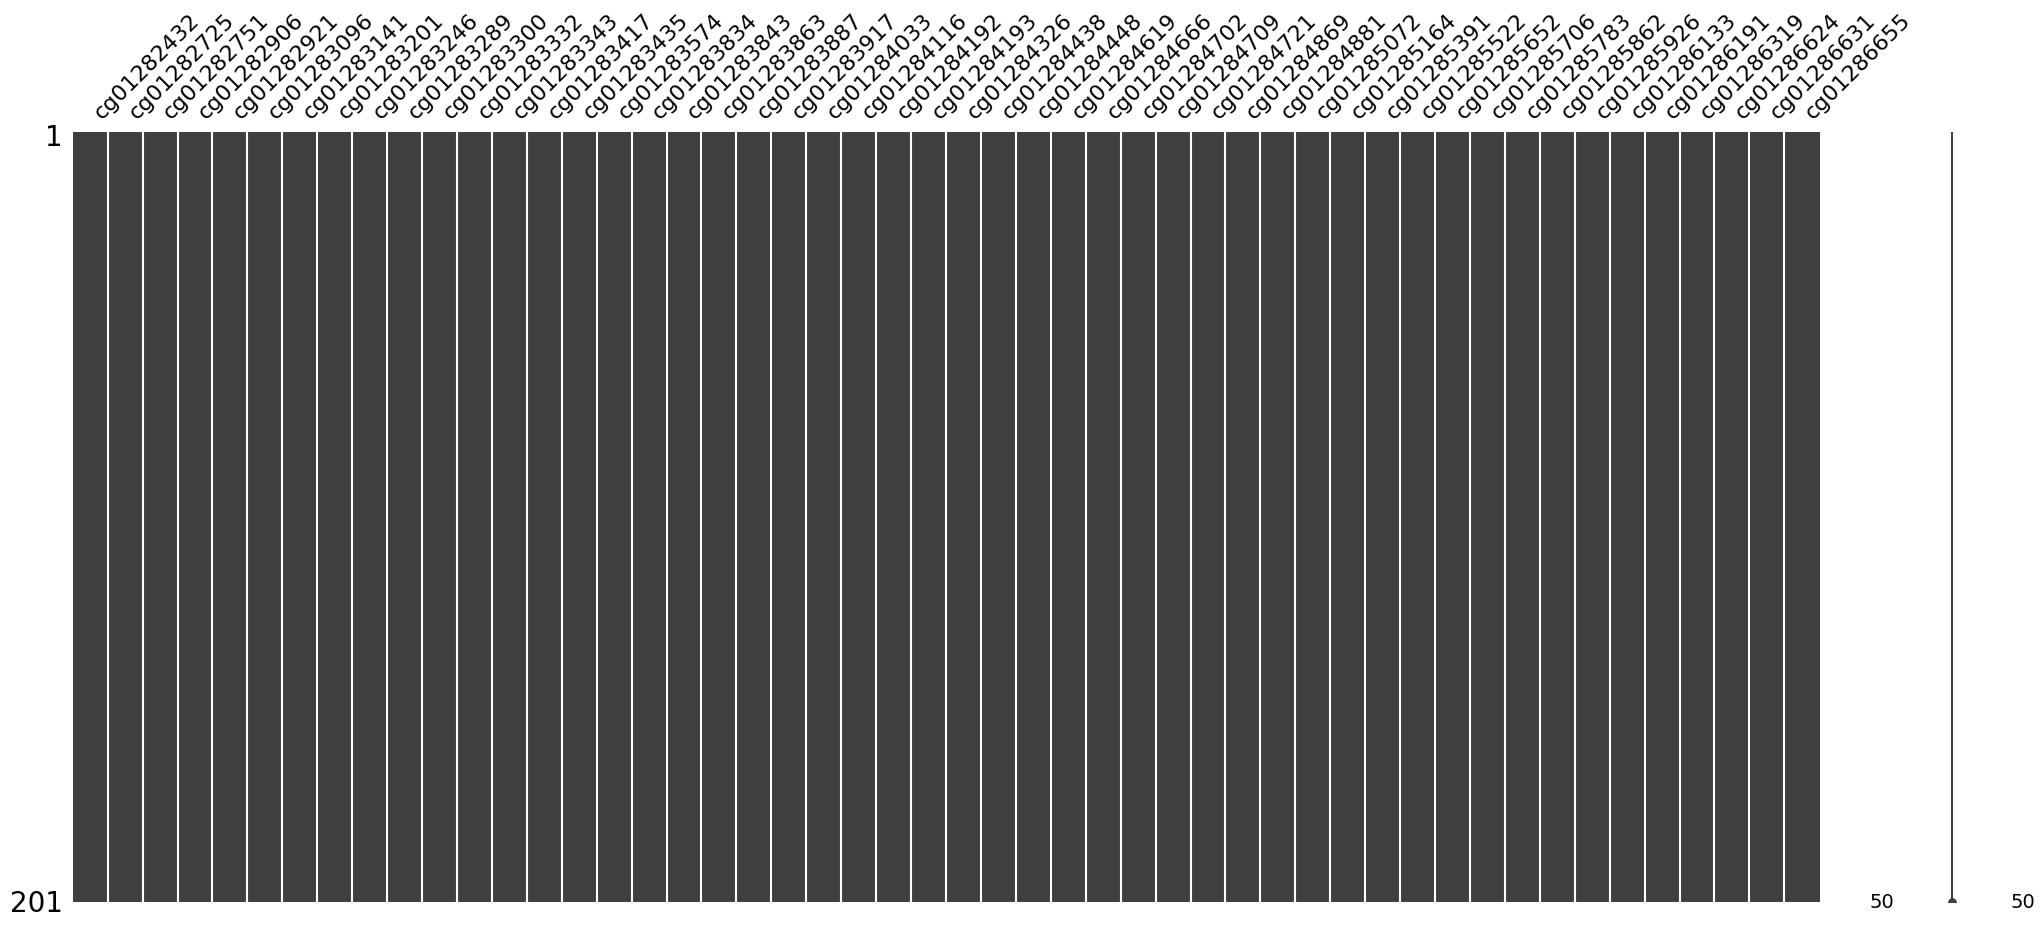

In [12]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 8. Remove outliers by PCA

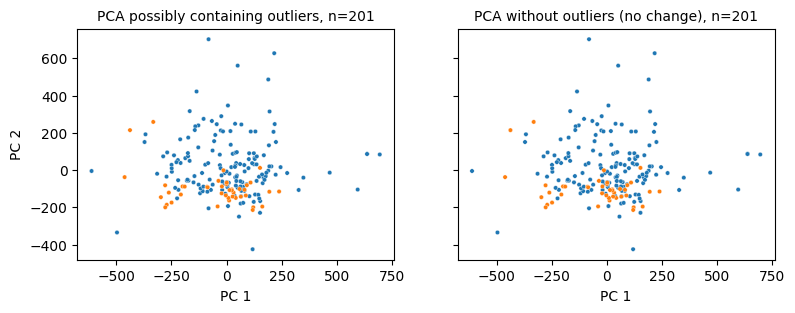

Removed 0 outliers. 201 samples remaining.


[]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define functions

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_labels['Clinical Trial']
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

# Execute functions

threshold = 1000
X_std = standardize_data(df)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df)
non_outliers = principal_df[principal_df['PC1'] < threshold]
df = filter_df(df, principal_df, threshold)

# Plot the PCA data

def plot_data(principal_df, non_outliers, threshold):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
    
    for df, ax, title in [(principal_df, ax1,
                                     'PCA possibly containing outliers, n=' + str(principal_df.shape[0])),
                                    (non_outliers, ax2,
                                     'PCA without outliers (no change), n=' + str(non_outliers.shape[0]))]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=False)
        ax.set_title(title, fontsize=10)
        # ax.axvline(x=threshold, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
    plt.show()

plot_data(principal_df, non_outliers, threshold)
print(f'Removed {principal_df.shape[0]-df.shape[1]} outliers. {df.shape[1]} samples remaining.')

# List outliers

outliers = principal_df[principal_df['PC1'] >= threshold].index.to_list()
outliers

## Transform to M-values

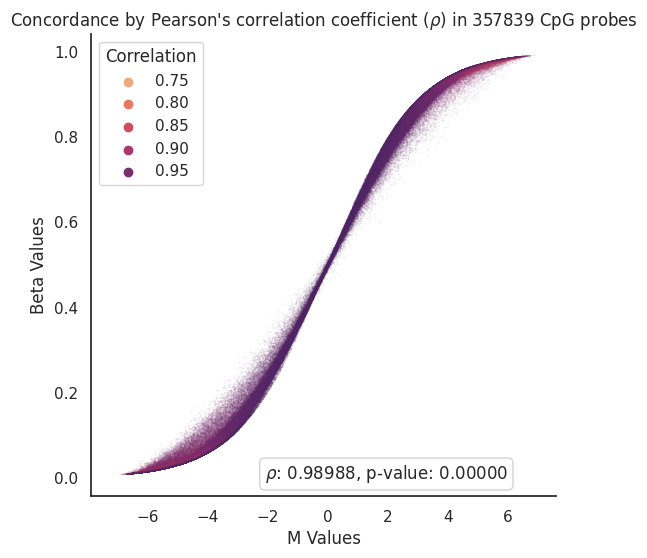

In [14]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Transpose the dataframe
df2 = df.T

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df2.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df2, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df2.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Step 9. Perform batch correction

- __pyCombat__: a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

### M-values

In [20]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_m_values = pycombat(data=x_train_m.T, batch=df_labels.loc[df_labels.index.isin(df2.T.columns)].sort_index()['Clinical Trial']).round(3)

print('Successfully corrected batch effects in the training dataset.')


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Successfully corrected batch effects in the training dataset.


### Beta-values

In [21]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_b_values = pycombat(data = df, batch = df_labels.loc[df_labels.index.isin(df.columns)].sort_index()['Clinical Trial']).round(3)

print('Succesfully corrected batch effects in the training dataset.')


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

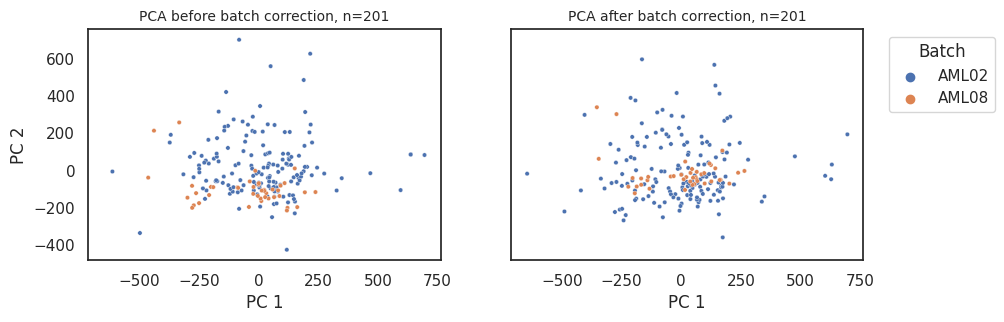

In [22]:
X_std = standardize_data(df_b_values)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df_b_values)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(principal_df, non_outliers)


### Save batch-corrected m-values dataframe for other analyses

In [22]:
# # Save file as csv
# df_m-values.to_csv(output_path+'methylation_dataset_m-values_StJude-201-dx-pts_batch-corrected_FMarchi-9-18-23.csv')

# # Save file as .RData
# import pyreadr
# pyreadr.write_rdata(output_path+'methylation_dataset_m-values_StJude-201-dx-pts_batch-corrected_FMarchi-9-18-23.RData',
#             df_m-values.reset_index())

## Save batch-corrected beta-values dataset

In [30]:
df_b_values = df_b_values.T

print(f'Dataset (df_b_values) contains {df_b_values.shape[1]} rows (5mC nucleotides/probes) and {df_b_values.shape[0]} columns (samples).')

df_b_values.to_pickle(output_path + '201samples-357839cpgs-withbatchcorrection-bvalues.pkl')

print(f'Successfuly saved in: {output_path}201samples-357839cpgs-withbatchcorrection-bvalues.pkl')


Dataset (df_b_values) contains 357839 rows (5mC nucleotides/probes) and 201 columns (samples).
Successfuly saved in: ../../Data/Intermediate_Files/201samples-357839cpgs-withbatchcorrection-bvalues.pkl


### Evaluate final sample size by batch

In [32]:
# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df_b_values.index)].sort_index()

# Add age categorization to the clinical data
df_labels = process_df_labels(df_labels)

# Save the clinical data labels
df_labels.to_csv(output_path + 'validation_clinical_data.csv')

df_labels['Clinical Trial'].value_counts(dropna=False)

Clinical Trial
AML02    159
AML08     42
Name: count, dtype: int64

Evaluate final sample size by diagnosis

In [37]:
df_labels['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                  47
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                       29
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11    23
AML with other rare recurring translocations                     10
AML with t(6;9)(p23;q34.1)/DEK::NUP214                            1
Name: count, dtype: int64

## Appendix 1. How to create this electronic notebook

1. Use Jupyter Book

    - Go to [jupyterbook.org](https://jupyterbook.org).
    - Follow the steps on their page.

2. Set up `toc.yml` and `_config.yml` files

    - `toc.yml` is the table of contents file. It contains the structure of the book.
    - `_config.yml` is the configuration file. It contains the configuration of the book.

3. Build the book

    ```bash
    jb build .
    ```

4. Push to Github

    ```bash
    git add .
    git commit -m "message"
    git push
    ```
    or do it through VSCode GUI.

5. Push to Github pages using `ghp-import`

    ```bash
    ghp-import -n -p -f -o _build/html
    ```

```{note}
`jupyterbook` works best on Linux/Mac. If on Windows, use WSL.
```

## Watermark

In [19]:
%load_ext watermark

In [20]:
%watermark -v -p methylcheck,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylcheck: 0.8.5
pandas     : 2.0.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

